# Data Dive Week 9: Decision Trees

This week we take a look at *decision trees*, our second type of classification model that brings deeper into the machine learning territory. We'll be using `scikit-learn` in today's exercise. 


***
![alt text](https://media.giphy.com/media/UsvHd1UncQq3u/source.gif)
    
This week we'll be illustrating how decision trees work using the Titanic survivor dataset available on [Kaggle](https://www.kaggle.com/c/titanic/data). We'll look at a create variety of variables to help us learn predict whether a given passenger on the Titanic was able to survive. There is a ton out on the web (including [here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)) about this dataset, as it's a popular among those just coming up to speed on machine learning classification models. Play around and use what you learn in class to join [the Kaggle competition](https://www.kaggle.com/c/titanic)!. 
***



### Data Dictionary

|Variable|Definition|Key|
| --- | --- |:---|
| survival | Survival | 0 = No, 1 = Yes |
| pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex	| Sex | | 	
| Age | Age in years | | 	
| sibsp	| # of siblings / spouses aboard the Titanic | 	| 
| parch	| # of parents / children aboard the Titanic | | 
| ticket | Ticket number | | 
| fare	| Passenger fare | 	| 
| cabin	| Cabin number| 	| 
| embarked | Port of Embarkation	| C = Cherbourg (France), Q = Queenstown (Ireland), S = Southampton (England) | 

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
!pip install -q pydot

# Used for visualizing trees, but not strictly necessary
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Load and summarize data

In [3]:
df = pd.read_csv('https://grantmlong.com/data/titanic.csv')

In [31]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,emb_S,emb_C,emb_Q,is_male,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,0,1,1


In [5]:
df.Survived.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

##### Summarize survival by age.

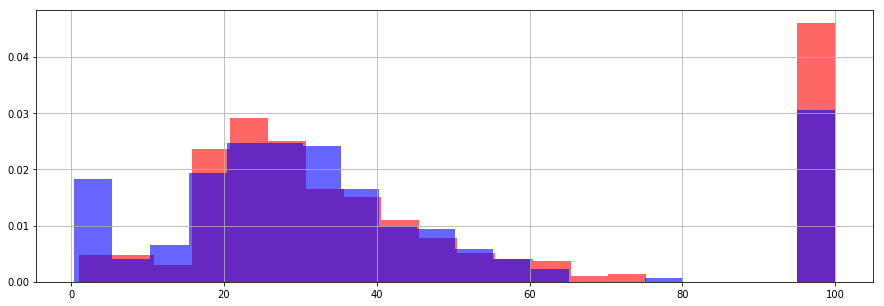

In [30]:
df.loc[(df.Survived==0), 'Age'].hist(bins=20, alpha=.6, color='red', density=True, figsize=[15, 5])
df.loc[(df.Survived==1), 'Age'].hist(bins=20, alpha=.6, color='blue', density=True)


##### Summarize survival by sex.

In [7]:
df[['Sex', 'Survived']].groupby('Sex').agg(['mean', 'count'])

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

##### Find and Count Nulls

In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### TODO: Summarize by Pclass, point of embarkment

# Data Cleaning and Feature Engineering

Sadly `sci-kit learn` will only let use numeric or boolean variables to train our decision tree, so let's transform some of our variables to address that. 
* Create booleans for each of the Embarkment points.
* Create a boolean for is_male. 
* Create a boolean for whether someone has a cabin. 

Moreover, some of our ages are missing, so let's enter the missing values as 100 for now. 

In [12]:
# Embarkment booleans
for k in df.Embarked.unique():
    if type(k)==str:
        df['emb_' + k] = (df.Embarked==k)*1

# Sex boolean
df['is_male'] = (df.Sex=='male')*1

# Has cabin boolean
df.loc[:, 'has_cabin'] = 0
df.loc[df.Cabin.isna(), 'has_cabin'] = 1

# Age fill
df.loc[df.Age.isna(), 'Age'] = 100

print(list(df))
df.head()

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,emb_S,emb_C,emb_Q,is_male,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,0,1,1


### TODO, time permitting: 
* Create identifiers for passengers in A, B, C, and D cabins

##### Let's assign a list of our clean and model ready features to a list so we can call them easily while training our model. 

In [13]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
            'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']

valid = df[features].notna().all(axis=1)
print(len(df), sum(valid))


891 891


# Building a Decision Tree

Now that we have variables in good shape, we can start modeling. Let's train a simple tree and see how it performs.   
Note: for the documentation on `DecisionTreeClassifier`, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

In [32]:
dtree=DecisionTreeClassifier(
    criterion='entropy', 
    random_state=20191021, 
    max_depth=3,
    #min_samples_split=2, 
    #min_samples_leaf=1, 
    #max_features=None, 
    #max_leaf_nodes=None, 
)

dtree.fit(df[features], df['Survived'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=20191020, splitter='best')

#### Visualize the tree. *Note: there's a strong chance this will not work if you do not have `graphviz` installed.* 
For more on visualizing decision trees see [here](https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/), and for more on installing graphviz see [here](https://graphviz.gitlab.io). To install `graphviz` on my Macbook Air, I used `brew install graphviz`.

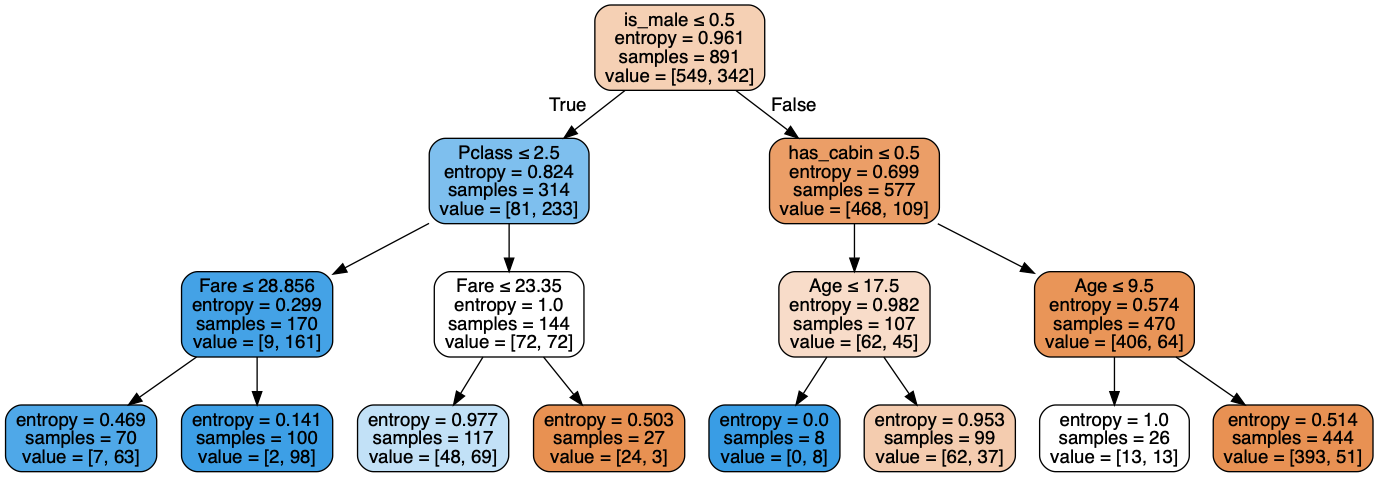

In [33]:
dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                feature_names=features,
                special_characters=True
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Calculate metrics from in-sample performance

In [16]:
pred_survival = dtree.predict(df[features])

print(confusion_matrix(df.Survived, pred_survival), '\n')
print('Accuracy:   %0.3f' % accuracy_score(df.Survived, pred_survival))
print('Precision:  %0.3f' % precision_score(df.Survived, pred_survival))
print('Recall:     %0.3f' % recall_score(df.Survived, pred_survival))


[[547   2]
 [ 10 332]] 

Accuracy:   0.987
Precision:  0.994
Recall:     0.971


### Wait, are nonlinear models actually doing better here? 
* Let's run a logistic regression to compare

In [17]:
logreg = LogisticRegression(random_state=20191021, solver='lbfgs')
logreg.fit(df[features], df['Survived'])
pred_survival = logreg.predict(df[features])

print(confusion_matrix(df.Survived, pred_survival), '\n')
print('Accuracy:   %0.3f' % accuracy_score(df.Survived, pred_survival))
print('Precision:  %0.3f' % precision_score(df.Survived, pred_survival))
print('Recall:     %0.3f' % recall_score(df.Survived, pred_survival))


[[472  77]
 [100 242]] 

Accuracy:   0.801
Precision:  0.759
Recall:     0.708


# Selecting Hyperparameters with Cross Validation
* First, we use the `KFold` function from `sci-kit learn` to generate five folds for cross validation. We can show the balance of the survivor rate among the different folds to get a better idea of what's going on.
* Next, we train a different decision tree model against each of the folds and track our performance.
* Finally, we track average cv metrics for different values of our hyperparameters. 


In [18]:
k_fold = KFold(n_splits=5, random_state=20181105)

In [19]:
# Print the number of observations and survivor rate  for 
for train_indices, test_indices in k_fold.split(df[features]):
     print('Train: n=%i, s_rate=%0.2f | test: n=%i, s_rate=%0.2f ' % 
           (df.loc[train_indices, 'Survived'].count(), 
            df.loc[train_indices, 'Survived'].mean(), 
            df.loc[test_indices, 'Survived'].count(),
            df.loc[test_indices, 'Survived'].mean(),
           )
          )


Train: n=712, s_rate=0.40 | test: n=179, s_rate=0.33 
Train: n=713, s_rate=0.37 | test: n=178, s_rate=0.44 
Train: n=713, s_rate=0.38 | test: n=178, s_rate=0.39 
Train: n=713, s_rate=0.38 | test: n=178, s_rate=0.40 
Train: n=713, s_rate=0.39 | test: n=178, s_rate=0.35 


#### Creating a function to fit our model and return relevant metrics makes it easy to track cross validation performance over different values of our parameters. 

In [20]:
def get_cv_results(classifier):
    results = []
    for train, test in k_fold.split(df[features]):
        classifier.fit(df.loc[train, features], df.loc[train, 'Survived'])
        y_predicted = classifier.predict(df.loc[test, features])
        accuracy = accuracy_score(df.loc[test, 'Survived'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)


#### Let's track mean and variance of accuracy for different values of the minimum samples per split. 

In [21]:
hp_values = range(10,200, 10)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=20180408, 
        min_samples_split=m, 
        #max_depth=m,
        #min_samples_leaf=m, 
        #max_features=m, 
        #max_leaf_nodes=m, 
    )

    mu, sigma = get_cv_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

10 0.7901450003138535 0.0270122278713061
20 0.792379637185362 0.012603934265261199
30 0.8047203565375682 0.011333753305803239
40 0.7901324461741259 0.017504444155684317
50 0.7901324461741259 0.013422327636255152
60 0.7912560416797438 0.011798720880804157
70 0.7912497646098802 0.010805340843469052
80 0.7901073378946707 0.015522123867716663
90 0.7968489109283786 0.016532488884220924
100 0.7968489109283786 0.016532488884220924
110 0.7901575544535809 0.02494225916978644
120 0.7733036218693113 0.031779782494929375
130 0.7676856443412216 0.02197160066407851
140 0.7676856443412216 0.02197160066407851
150 0.7676856443412216 0.02197160066407851
160 0.7676856443412216 0.02197160066407851
170 0.7676856443412216 0.02197160066407851
180 0.7676856443412216 0.02197160066407851
190 0.7676856443412216 0.02197160066407851


Text(0.5, 0, 'Minimum Samples Per Leaf')

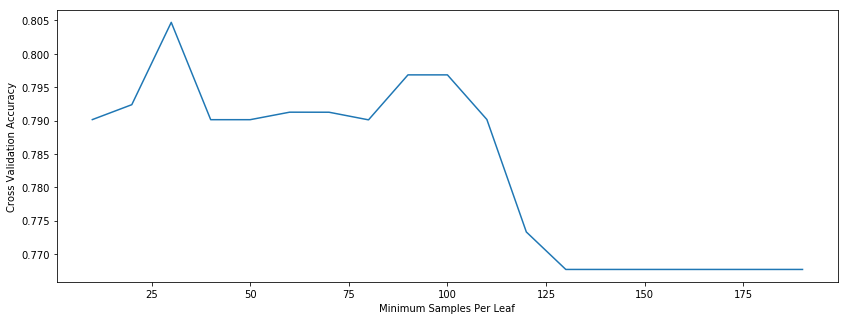

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Minimum Samples Per Leaf')

Text(0.5, 0, 'Minimum Samples Per Leaf')

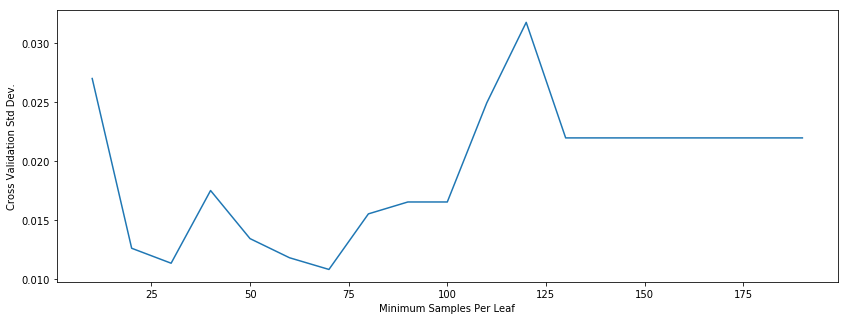

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Minimum Samples Per Leaf')

### Pretty cool, right? We can take a quick look again at how these results compare to logistic regression.

* What do you make of these results?
* Is this a better model? Why or why not?

In [24]:
logreg = LogisticRegression(random_state=20191021, solver='lbfgs')
get_cv_results(logreg)


(0.781175067478501, 0.029039046791031302)

# Selecting Our Model and Applying It to Our Test Set
#### From this, it seems like `min_samples_split=100` might provide our best fit. We can train our best model using that value.  

We can then read in our holdout test set from the Kaggle competition to enter our predictions. We'll first double check and see if our model makes sense by taking a closer look at our predictions.

In [25]:
dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=20191021, 
        min_samples_split=100, 
    )

# Here we train our final model against all of our validation data. 
dtree.fit(df.loc[:, features], df.loc[:, 'Survived'])


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=20181105, splitter='best')

##### Read in our test data and apply the same transformations as our training set.

In [26]:
test_df = pd.read_csv('https://grantmlong.com/data/titanic_test.csv')

# Embarkment booleans
for k in test_df.Embarked.unique():
    if type(k)==str:
        test_df['emb_' + k] = (test_df.Embarked==k)*1

# Sex boolean
test_df['is_male'] = (test_df.Sex=='male')*1

# Has cabin boolean
test_df.loc[:, 'has_cabin'] = 0
test_df.loc[test_df.Cabin.isna(), 'has_cabin'] = 1

# Age fill
test_df.loc[test_df.Age.isna(), 'Age'] = 100

# Fare fill
test_df.loc[test_df.Fare.isna(), 'Fare'] = test_df.loc[test_df.Fare.notna(), 'Fare'].median()

print(list(test_df))
test_df.head()

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'emb_Q', 'emb_S', 'emb_C', 'is_male', 'has_cabin']


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,emb_Q,emb_S,emb_C,is_male,has_cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,0,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0,0,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,1,0,0,1


##### Rank the most likely to survive according to our model. 

In [27]:
# Calculate the probability of 
test_probabilities = dtree.predict_proba(test_df[features])[:,1]
test_df['survival_likelihood'] = test_probabilities

readable_features =  ['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 
                      'Ticket', 'Fare', 'Cabin', 'Embarked', 'survival_likelihood']

# Find the rankings based on the probabilities
probability_rankings = np.argsort(test_probabilities)

##### Most Likely to Survive:

In [28]:
test_df.loc[probability_rankings[-20:], readable_features]

,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,survival_likelihood
74,"Geiger, Miss. Amalie",1,female,35.0,0,0,113503,211.5000,C130,C,0.989899
272,"Clark, Mrs. Walter Miller (Virginia McDowell)",1,female,26.0,1,0,13508,136.7792,C89,C,0.989899
385,"Herman, Miss. Kate",2,female,24.0,1,2,220845,65.0000,NaN,S,0.989899
239,"Douglas, Mrs. Walter Donald (Mahala Dutton)",1,female,48.0,1,0,PC 17761,106.4250,C86,C,0.989899
364,"Harder, Mrs. George Achilles (Dorothy Annan)",1,female,25.0,1,0,11765,55.4417,E50,C,0.989899
92,"Davidson, Mrs. Thornton (Orian Hays)",1,female,27.0,1,2,F.C. 12750,52.0000,B71,S,0.989899
96,"Cavendish, Mrs. Tyrell William (Julia Florence...",1,female,76.0,1,0,19877,78.8500,C46,S,0.989899
368,"Gibson, Mrs. Leonard (Pauline C Boeson)",1,female,45.0,0,1,112378,59.4000,NaN,C,0.989899
371,"Wilson, Miss. Helen Alice",1,female,31.0,0,0,16966,134.5000,E39 E41,C,0.989899
100,"Stengel, Mrs. Charles Emil Henry (Annie May Mo...",1,female,43.0,1,0,11778,55.4417,C116,C,0.989899


##### Most Likely to Die:

In [29]:
test_df.loc[probability_rankings[:20], readable_features]

,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,survival_likelihood
0,"Kelly, Mr. James",3,male,34.5,0,0,330911,7.8292,NaN,Q,0.0
255,"MacKay, Mr. George William",3,male,100.0,0,0,C.A. 42795,7.5500,NaN,S,0.0
260,"de Messemaeker, Mr. Guillaume Joseph",3,male,36.5,1,0,345572,17.4000,NaN,S,0.0
266,"Chisholm, Mr. Roderick Robert Crispin",1,male,100.0,0,0,112051,0.0000,NaN,S,0.0
78,"Aldworth, Mr. Charles Augustus",2,male,30.0,0,0,248744,13.0000,NaN,S,0.0
278,"Ware, Mr. John James",2,male,30.0,1,0,CA 31352,21.0000,NaN,S,0.0
285,"Dennis, Mr. William",3,male,36.0,0,0,A/5 21175,7.2500,NaN,S,0.0
286,"Franklin, Mr. Charles (Charles Fardon)",3,male,100.0,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,0.0
294,"Wittevrongel, Mr. Camille",3,male,36.0,0,0,345771,9.5000,NaN,S,0.0
296,"Laroche, Miss. Louise",2,female,1.0,1,2,SC/Paris 2123,41.5792,NaN,C,0.0


# Flight Data, Revisited
### Would a tree based model make more sense for our flight prediction problem? Why or why not?

![plane](https://media.giphy.com/media/IlbFNPL3bE6DC/source.gif)

In [46]:
flight_df = pd.read_csv('https://grantmlong.com/data/Flights-July2019.csv')
flight_df['bad'] = flight_df['DIVERTED'] + flight_df['CANCELLED'] + (flight_df['ARR_DELAY']>=30)

all_features = []
# Categorical features
top = 20
categorical_features = ['OP_CARRIER', 'DEST', 'ORIGIN', 'DAY_OF_WEEK']
for each_feature in categorical_features:
    for f in flight_df[each_feature].value_counts().index[:top].to_list():
        flight_df[each_feature+'='+str(f)] = (flight_df[each_feature]==f)*1
        all_features.append(each_feature+'='+str(f))
        
# Grouped Categorical features
flight_df['MORNING'] = (flight_df['CRS_DEP_TIME']<1000)*1
flight_df['AFTERNOON'] = ((flight_df['CRS_DEP_TIME']>=1000) & (flight_df['CRS_DEP_TIME']<=1500))*1
flight_df['EVENING'] = (flight_df['CRS_DEP_TIME']>1500)*1
all_features = all_features + ['MORNING', 'AFTERNOON', 'EVENING']
      
# Continuous features
continuous_features = ['DISTANCE', 'CRS_ELAPSED_TIME']
flight_df.loc[flight_df.CRS_ELAPSED_TIME.isna(), 'CRS_ELAPSED_TIME'] = 180
for each_feature in continuous_features:
    all_features.append(each_feature)

# Adding a constant
flight_df['constant'] = 1
all_features.append('constant')
    


In [49]:
X = flight_df[all_features].values
y = flight_df['bad'].values

lreg = LogisticRegression(random_state=20191021).fit(X, y)
print('The accuracy of our logistic regression is %0.1f%%' % (lreg.score(X, y)*100))

tree = DecisionTreeClassifier(criterion='entropy', random_state=20191021, min_samples_leaf=100).fit(X, y)
print('The accuracy of our decision tree is %0.1f%%' % (tree.score(X, y)*100))


The accuracy of our logistic regression is 83.6%


In [67]:
tree_precision = []
lreg_precision = []
tree_recall = []
lreg_recall = []

thresholds = np.arange(0.05, 0.65, 0.05)
for threshold in thresholds:
    
    flight_df['tree_predicted'] = (tree.predict_proba(X)[:,1]>=threshold)*1
    tree_precision.append(flight_df.loc[flight_df['tree_predicted']==1, 'bad'].mean())
    tree_recall.append(flight_df.loc[flight_df['bad']==1, 'tree_predicted'].mean())
    
    flight_df['lreg_predicted'] = (lreg.predict_proba(X)[:,1]>=threshold)*1
    lreg_precision.append(flight_df.loc[flight_df['lreg_predicted']==1, 'bad'].mean())
    lreg_recall.append(flight_df.loc[flight_df['bad']==1, 'lreg_predicted'].mean())


Text(0.5, 1.0, 'Precision Across Thresholds')

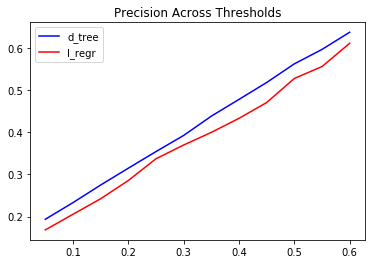

In [68]:
plt.plot(thresholds, tree_precision, color='b', label='d_tree')
plt.plot(thresholds, lreg_precision, color='r', label='l_regr')
plt.legend()    
plt.title('Precision Across Thresholds')

Text(0.5, 1.0, 'Recall Across Thresholds')

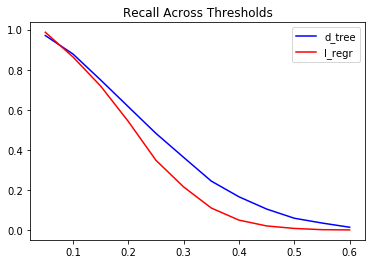

In [69]:
plt.plot(thresholds, tree_recall, color='b', label='d_tree')
plt.plot(thresholds, lreg_recall, color='r', label='l_regr')
plt.legend()    
plt.title('Recall Across Thresholds')